# Bounce Analysis - Tennis Ball Part 3

## Development Objective of this notebook

We now have the frames in which the ball was located, let's now get the position of the ball in those moments in order to get the exact coordinates

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import cv2
import pickle

In [2]:
# Load the saved coordinates (they are inverted)
with open('Pickles/ball_coords_no_court_83.pkl', 'rb') as f:
    q = pickle.load(f)
len(q)

447

In [3]:
# Reverse the list
q=q[::-1]

coordenada_x = [q[i][0] if q[i] is not None else np.NaN for i in range(len(q))]
coordenada_y = [q[i][1] if q[i] is not None else np.NaN for i in range(len(q))]

coordenada_x = np.array(coordenada_x)
coordenada_y = np.array(coordenada_y)

# Interpolate the missing values
coordenada_x_filled = pd.Series(coordenada_x).interpolate().values.astype(int)
coordenada_y_filled = pd.Series(coordenada_y).interpolate().values.astype(int)

# Fix the values are borken due to the interpolation
coordenada_x_filled[coordenada_x_filled < 0] = 949
coordenada_y_filled[coordenada_y_filled < 0] = 310

# Import the frames where a bounce occur
with open('Pickles/peaks_2.pkl', 'rb') as f:
    peaks_dict = pickle.load(f)

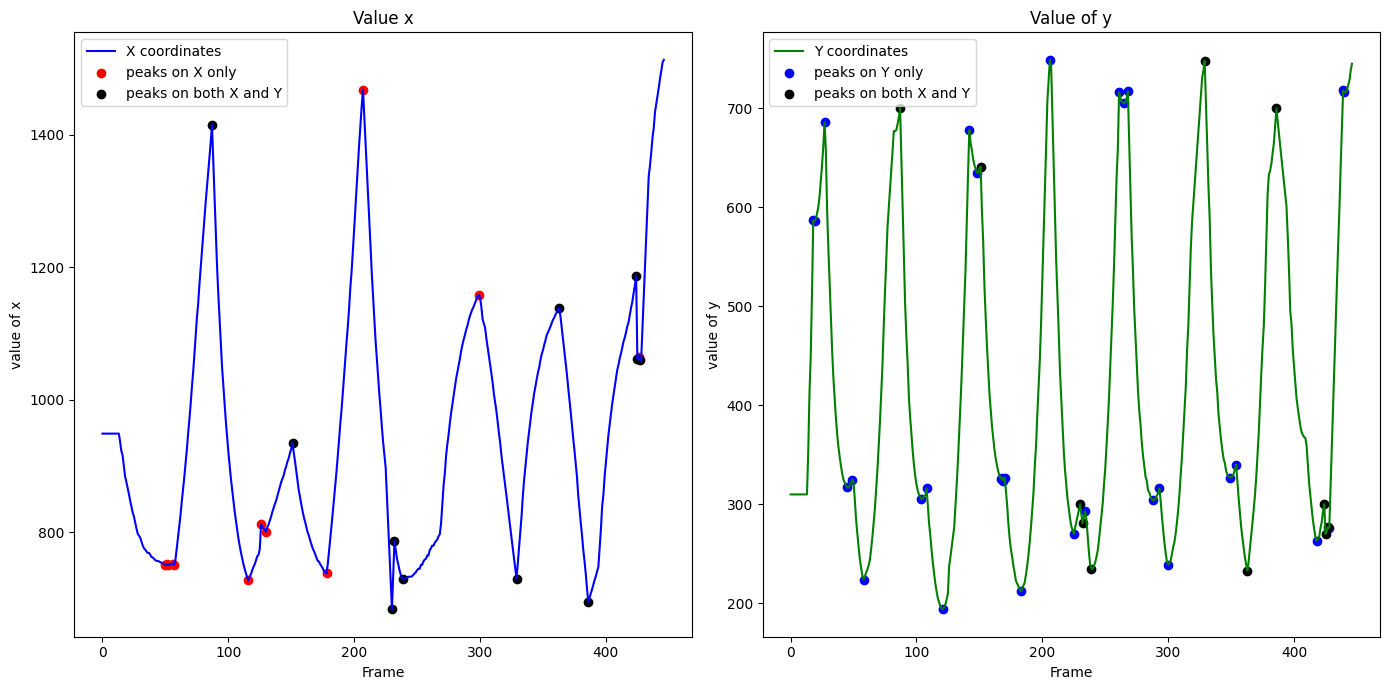

In [4]:
peaks_x = peaks_dict["peaks_x_only"]
peaks_y = peaks_dict["peaks_y_only"]
peaks_both = peaks_dict["peaks_both"]

# Plotting the derivatives in two separate 2D plots
plt.figure(figsize=(14, 7))

# Plot derivative of x
plt.subplot(1, 2, 1)
plt.plot(coordenada_x_filled, label='X coordinates', color='blue')
plt.scatter(peaks_x, coordenada_x_filled[peaks_x], color='red', label='peaks on X only')
plt.scatter(peaks_both, coordenada_x_filled[peaks_both], color='black',label="peaks on both X and Y")
plt.xlabel('Frame')
plt.ylabel('value of x')
plt.title('Value x')
plt.legend()
plt.tight_layout()


# Plot derivative of y
plt.subplot(1, 2, 2)
plt.plot(coordenada_y_filled, label='Y coordinates', color='green')
plt.scatter(peaks_y, coordenada_y_filled[peaks_y], color='blue', label='peaks on Y only')
plt.scatter(peaks_both, coordenada_y_filled[peaks_both], color='black', label="peaks on both X and Y")
plt.legend()
plt.xlabel('Frame')
plt.ylabel('value of y')
plt.title('Value of y')
plt.tight_layout()

plt.show()

# Identifying the coordinates on the court

Now that we have a method of identifying the frame in which a peak occurs, let's now use camera geometry to identify where exactly the bounce happens. 

In order to do that, let's identify the tennins court lines and then rectify it, with the rectification process done, we can transform the coordinates from the game view into the coordinates of the absolute position(retified position)

In [5]:
from visualize import *

input_video_path = "VideoInput/INPUT_play_5.mp4"
rectifyed_video_path = "VideoOutput/rec_2_output_play_5.mp4"

In [6]:
peaks_combined = np.concatenate((peaks_x, peaks_y, peaks_both))
sorted_peaks = np.sort(peaks_combined)
sorted_peaks

array([ 18,  19,  27,  45,  49,  50,  51,  52,  56,  57,  58,  87, 104,
       108, 116, 121, 126, 130, 142, 148, 151, 167, 168, 169, 170, 178,
       183, 206, 207, 225, 230, 232, 234, 239, 261, 265, 268, 288, 293,
       299, 300, 329, 349, 354, 363, 386, 418, 424, 425, 426, 427, 428,
       439, 440])

In [7]:
(coordenada_y_filled.max() - coordenada_y_filled).max()

555

In [8]:
coords_y = coordenada_y_filled
frame_number = 45
coords_y.max() - coords_y[:frame_number + 1]

array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439,
       439, 397, 337, 299, 236, 162, 163, 161, 155, 149, 138, 122, 106,
        87,  63,  91, 151, 191, 224, 260, 294, 321, 342, 362, 378, 391,
       401, 410, 418, 424, 427, 430, 432])

In [9]:
coords_y[:frame_number + 1]

array([310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310,
       310, 352, 412, 450, 513, 587, 586, 588, 594, 600, 611, 627, 643,
       662, 686, 658, 598, 558, 525, 489, 455, 428, 407, 387, 371, 358,
       348, 339, 331, 325, 322, 319, 317])

In [10]:
#show_specific_frame_and_full_path(input_video_path, 147, coordenada_x_filled, coordenada_y_filled,peaks_both, peaks_x, peaks_y )

In [11]:
#show_specific_frame_and_coord(input_video_path, 147,coordenada_x_filled[147] ,coordenada_y_filled[147])

# Transforming the coordinates with the rectifyied matrix

Now that we have the coordinates of the ball tracked and their moments in the video in which a possible bounce occurs, we now use the transformation Matrix (M) obtained by using the paralel lines from the court and obtain the coordinates of each bounce in the verticall (rectified) view

In [12]:
# Load the saved coordinates
with open('Pickles/M.pkl', 'rb') as f:
    M = pickle.load(f)
print(M)

[[ 5.05381234e+00  2.78611570e+00 -3.84729714e+03]
 [ 2.14083279e-02 -3.95139782e+00  3.12265663e+03]
 [-4.67976838e-06  3.00589508e-03  1.00000000e+00]]


## Analysing the transformation

In [13]:
sorted_peaks

array([ 18,  19,  27,  45,  49,  50,  51,  52,  56,  57,  58,  87, 104,
       108, 116, 121, 126, 130, 142, 148, 151, 167, 168, 169, 170, 178,
       183, 206, 207, 225, 230, 232, 234, 239, 261, 265, 268, 288, 293,
       299, 300, 329, 349, 354, 363, 386, 418, 424, 425, 426, 427, 428,
       439, 440])

As seen in class, we can get an specific point by the simple matrix multiplication below:

In [14]:
x = coordenada_x_filled[169]
y = coordenada_y_filled[169]

homogeneous_coord = np.array([x, y, 1])


In [15]:
rectified_coord = M @ homogeneous_coord

In [16]:
rectified_coord

array([ 931.67841086, 1858.8239253 ,    1.97032062])

In [17]:
rectified_x = rectified_coord[0] / rectified_coord[2]
rectified_y = rectified_coord[1] / rectified_coord[2]

In [18]:
int(rectified_x)

472

In [19]:
int(rectified_y)

943

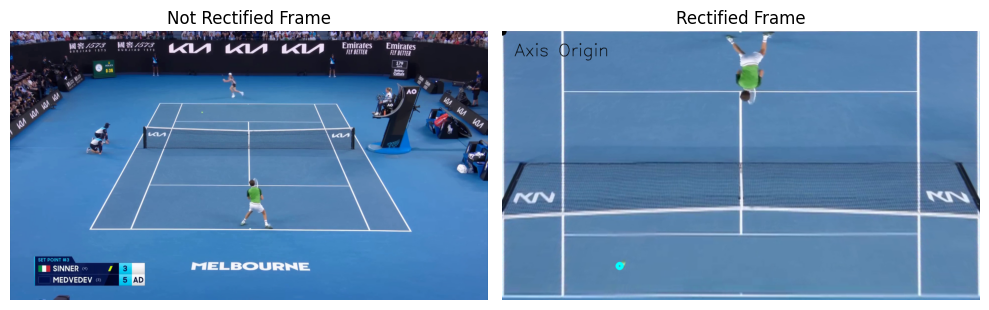

In [20]:
plot_top_down_view(input_video_path, M, 169, (int(rectified_x), int(rectified_y)))

As we can see, the matrix correctly identifies the right place of the ball, making it possible to locate the coordinate of bounce in the precise frame in which the bounce is detected.  

In [21]:
from bounce import *

## Aplying to all tracked bounces

In [22]:
final_coords=compute_rectified_coords(M, coordenada_x_filled, coordenada_y_filled, peaks=sorted_peaks)

In [23]:
final_coords[0][1]

297

In [24]:
'''for i in range(len(final_coords)//7):
    x_final = final_coords[i][0]
    y_final = final_coords[i][1]
    print(f"frame number {sorted_peaks[i]}", "rectified coordinates:", x_final, y_final)
    plot_top_down_view(input_video_path, M, sorted_peaks[i], (x_final, y_final))'''

'for i in range(len(final_coords)//7):\n    x_final = final_coords[i][0]\n    y_final = final_coords[i][1]\n    print(f"frame number {sorted_peaks[i]}", "rectified coordinates:", x_final, y_final)\n    plot_top_down_view(input_video_path, M, sorted_peaks[i], (x_final, y_final))'

As we can see in the final results, the bounce coordinartes corectly identify the position of the ball, giving its absolute coordinates.

Given that the y axis has a limit of 1080 frames, everytime the players that is farest from the camera hits the ball (creating a bounce), the coordinates correctly indicate that the ball was bounced outside the delimited area of the court (showing a Y coordinate value above 1080)

# Setting the coordinates for real metrics of the tennis court

Now that we have the positions regarding the pixels of the image, let's now adjust the coordinates for the real size of a tennis court. In order to obtain the right position of the bounce.

<img src="Sources/tenis_court_image.jpg" width="700"> 


### On X
1920px $\rightarrow$ 10.97m

### On Y
1080px $\rightarrow$ 23.77m

In [32]:
absolute_position = np.zeros((len(final_coords), 2))

# turn the coordinates into relative values proportional to the court
absolute_position[:,0] = final_coords[:,0]/1920
absolute_position[:,1] = final_coords[:,1]/1080

# turn the values into the court coordinates
absolute_position[:,0] = np.round(absolute_position[:,0]*10.97,2)
absolute_position[:,1] = np.round(absolute_position[:,1]*23.77,2)

In [26]:
'''for i in range(len(final_coords)//5):
    x_final = final_coords[i][0]
    y_final = final_coords[i][1]
    print(f"frame number {sorted_peaks[i]}", "absolute coordinates in meters:", absolute_position[i][0], absolute_position[i][1])
    plot_top_down_view(input_video_path, M, sorted_peaks[i], (x_final, y_final))'''

'for i in range(len(final_coords)//5):\n    x_final = final_coords[i][0]\n    y_final = final_coords[i][1]\n    print(f"frame number {sorted_peaks[i]}", "absolute coordinates in meters:", absolute_position[i][0], absolute_position[i][1])\n    plot_top_down_view(input_video_path, M, sorted_peaks[i], (x_final, y_final))'

## Finetunning 

Now let's make some arrangements on the code in order to have better results. As we can see in the provided examples, some of the "bounces" are identified more than once in consecutive frames, in order to make this better, let's make a padding that allows only one bounce every 5 frames. 

In [27]:
sorted_peaks

array([ 18,  19,  27,  45,  49,  50,  51,  52,  56,  57,  58,  87, 104,
       108, 116, 121, 126, 130, 142, 148, 151, 167, 168, 169, 170, 178,
       183, 206, 207, 225, 230, 232, 234, 239, 261, 265, 268, 288, 293,
       299, 300, 329, 349, 354, 363, 386, 418, 424, 425, 426, 427, 428,
       439, 440])

In [28]:
filtered_peaks = []
for i in range(len(sorted_peaks)-1):
    if sorted_peaks[i+1] - sorted_peaks[i] > 4:
         filtered_peaks.append(sorted_peaks[i])


filtered_peaks = np.array(filtered_peaks)
len(filtered_peaks)

28

As we can see in the results, the filtering eliminate redundant bounces in the frames, making it better to analyse in further detail

## Generating videos and plots

In [29]:
#video_with_Y(input_video_path,0, coordenada_y_filled, filtered_peaks, "eder.mp4")

In [30]:
#video_with_coordinates(input_video_path, frame_number, coordenada_x_filled, coordenada_y_filled, filtered_peaks, "coodinate_map.mp4")

## Position Analysis

/home/azank/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


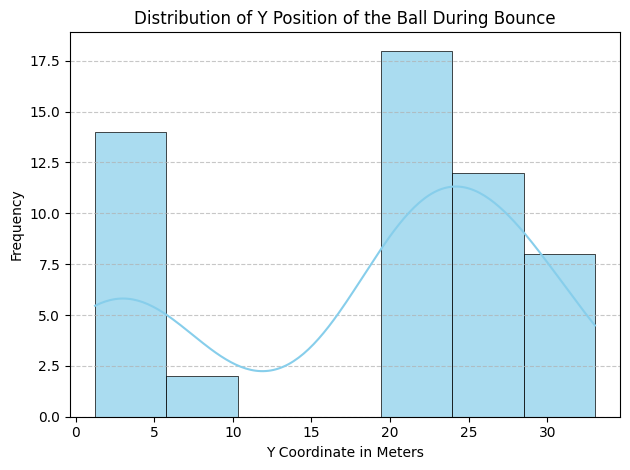

In [43]:
import seaborn as sns
sns.histplot(absolute_position[:,1],kde=True,bins='auto',color='skyblue',edgecolor='black', linewidth=0.5, alpha=0.7,)

plt.xlabel('Y Coordinate in Meters')
plt.ylabel('Frequency')
plt.title('Distribution of Y Position of the Ball During Bounce')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/home/azank/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


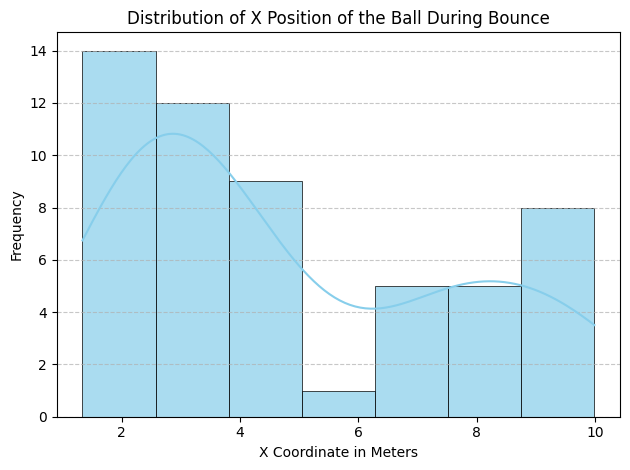

In [44]:
import seaborn as sns
sns.histplot(absolute_position[:,0],kde=True,bins='auto',color='skyblue',edgecolor='black', linewidth=0.5, alpha=0.7,)

plt.xlabel('X Coordinate in Meters')
plt.ylabel('Frequency')
plt.title('Distribution of X Position of the Ball During Bounce')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [45]:
absolute_position[:,0].mean()

4.832777777777778

In [46]:
absolute_position[:,1].mean()

18.345